# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn

# There are no null values in either of the datasets.
# df_offers.info()
# df_transactions.info()

# Use pivot_table to rearrange the table to use offer_id as the columns, values as n, and index as customer_name
# Reset the index to turn customer_name into a column
df_transactions_piv = df_transactions.pivot_table(values='n', index='customer_name', columns='offer_id').reset_index()
#df_transactions_piv.head()

# Data now consists of a fair amount of null (NaN) values. Fill these NaN values with 0s
df_transactions_piv.fillna(value=0, inplace=True)
#df_transactions_piv.head()

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Minimizing the sum of squares error (SS) would represent better clusterings because that means there is less spread from the centroid to the data points related to the cluster.

In [5]:
# your turn

# Create the matrix of offers
x_cols = df_transactions_piv.drop('customer_name', axis=1).values
#print (x_cols[:5])

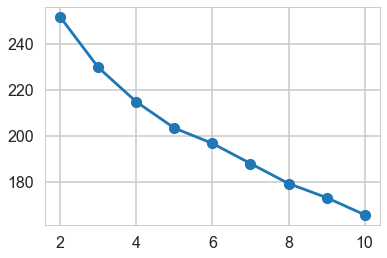

In [6]:
# Import KMeans from sklearn.cluster and numpy as np

from sklearn.cluster import KMeans
import numpy as np

# Create a loop to try multiple K values for KMeans

range_n_clusters = np.arange(2,11)

SS = np.empty(len(range_n_clusters))
for i, k in enumerate(range_n_clusters):
    clf = KMeans(n_clusters=k)
    clf.fit(x_cols)
    SS[i] = clf.inertia_

# Plot the sum of squared error against K values on a scatter plot    

plt.plot(range(2,11), SS, '-o')
plt.show()

The elbow method here doesn't seem very reliable as the decline in SS doesn't have really change too much. However, we'll be using K = 3 as it it appears to slow down slightly after this point.

It appears that using the elbow method isn't always intuitive where the best K value is.

(array([36.,  0.,  0.,  0.,  0., 48.,  0.,  0.,  0., 16.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

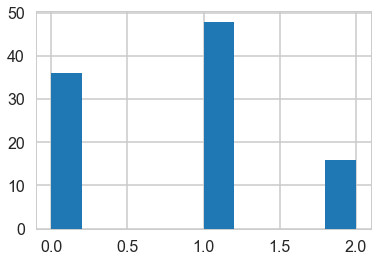

In [7]:
# Make a bar chart showing the number of points in each cluster for k-means under the best  K .

km_clf = KMeans(n_clusters=3, random_state=22)
km_clf.fit(x_cols)
data = km_clf.predict(x_cols)

plt.hist(data, histtype='bar')

# The results to the bar chart fluctuates so we'll set a random_state parameter.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [89]:
# # Your turn.

# # Import silhouette_score from sklearn.metrics
# from sklearn.metrics import silhouette_score, silhouette_samples
# import matplotlib.cm as cm

# # Create a series of silhouette plots
# for cluster in range_n_clusters:
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)
    
# # Subplot 1 will be for the silhouette plot
#     ax1.set_xlim([-0.1, 1])
#     ax1.set_ylim([0, len(x_cols) + (cluster + 1) * 10])
#     ax1.set_yticks([])
#     ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# # Initialize KMeans with each K cluster and fit_predict
#     sil_clf = KMeans(n_clusters=cluster, random_state=22)
#     sil_labels = sil_clf.fit_predict(x_cols)
    
# # Compute the silhouette_score
#     silhouette_avg = silhouette_score(x_cols, sil_labels)
#     print ("{} clusters: {}".format(cluster, silhouette_avg))
    
#     sample_sil_value = silhouette_samples(x_cols, sil_labels)

#     y_lower = 10
#     for i in range(cluster):
#         ith_cluster_s_value = sample_sil_value[sil_labels == i]
        
#         ith_cluster_s_value.sort()
        
#         size_cluster_i = ith_cluster_s_value.shape[0]
#         y_upper = y_lower + size_cluster_i
        
#         color = cm.spectral(float(i) / cluster)
#         ax1.fill_betweenx(np.arange(10, y_upper),
#                          0, ith_cluster_s_value,
#                          facecolor=color, edgecolor=color, alpha=0.7)
        
#         y_lower += 10
    
# # Create the vertical line for the silhouette_avg
#    # ax1.axvline(x=silhouette_avg, color='r', line='--')
    
# # Create the scatter plots for each K cluster
#     cm.spectral(sil_labels.astype(float) / cluster)
#     ax2.scatter(avg_x_cols, sil_labels, marker='o',
#                c='white', alpha=1, s=200, edgecolor='k')
    
#     for i, c in enumerate(sil_clf.cluster_centers_):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                    s=50, edgecolor='k')
        
#     plt.show()

2 clusters: 0.09174871508750351
3 clusters: 0.12101628521627421
4 clusters: 0.12166825588215796
5 clusters: 0.10450806626351468
6 clusters: 0.12358173219173922
7 clusters: 0.11542272279915279
8 clusters: 0.13873269477076455
9 clusters: 0.1251855666469388
10 clusters: 0.1313521127026779


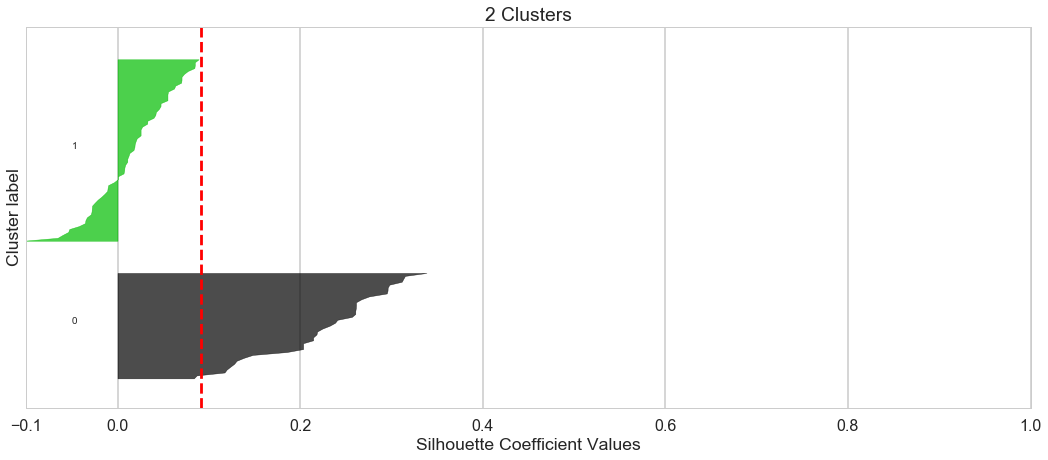

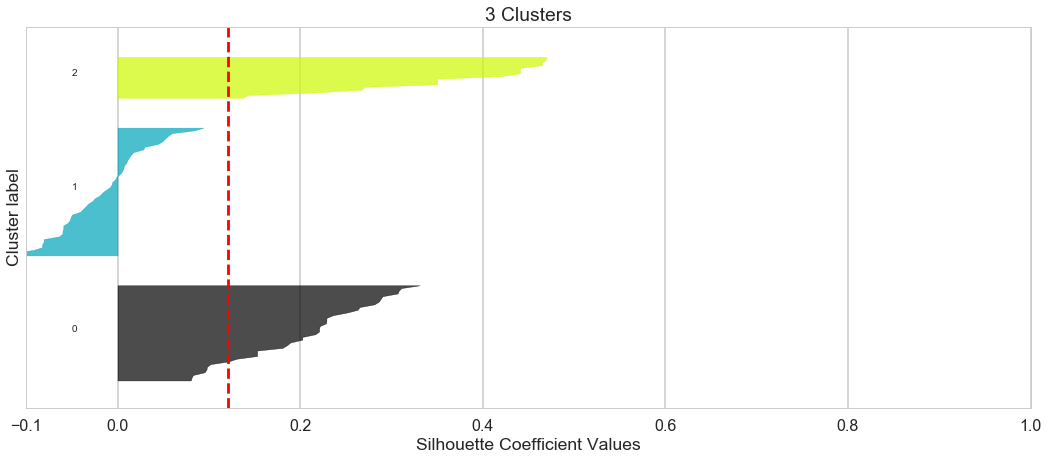

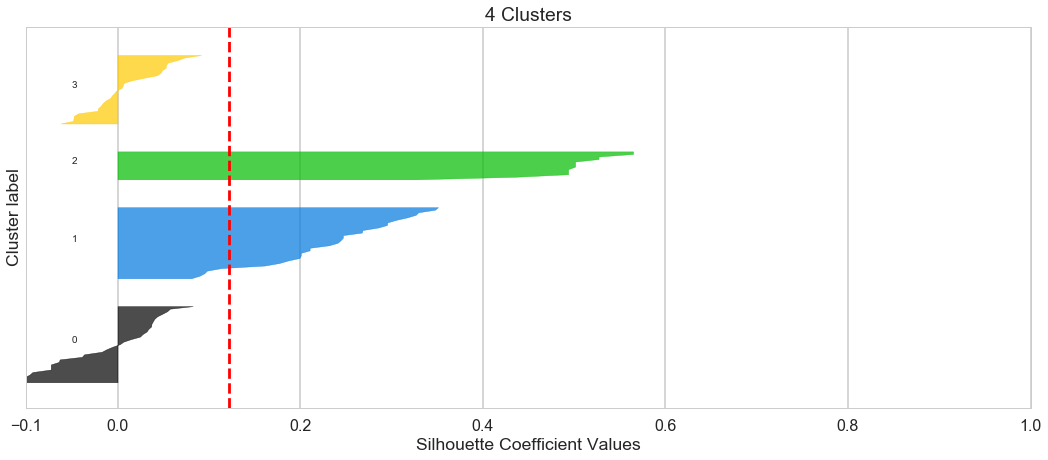

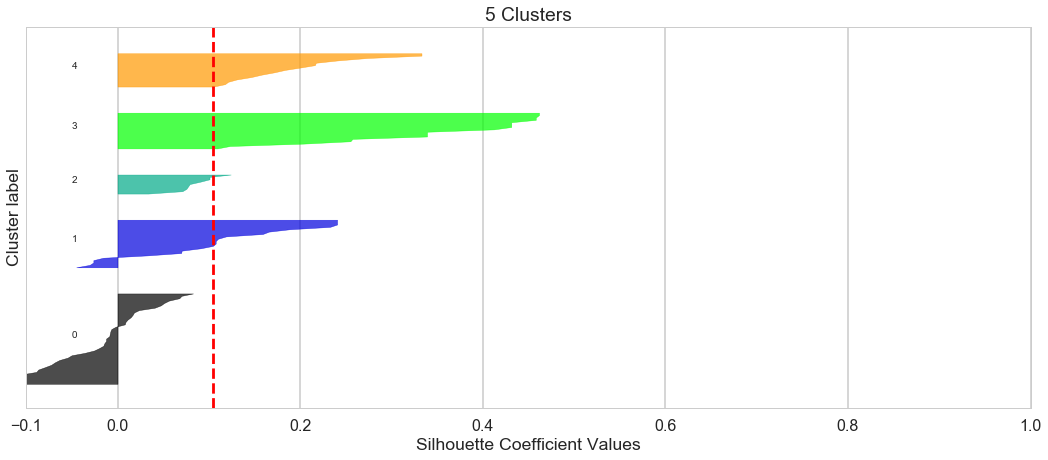

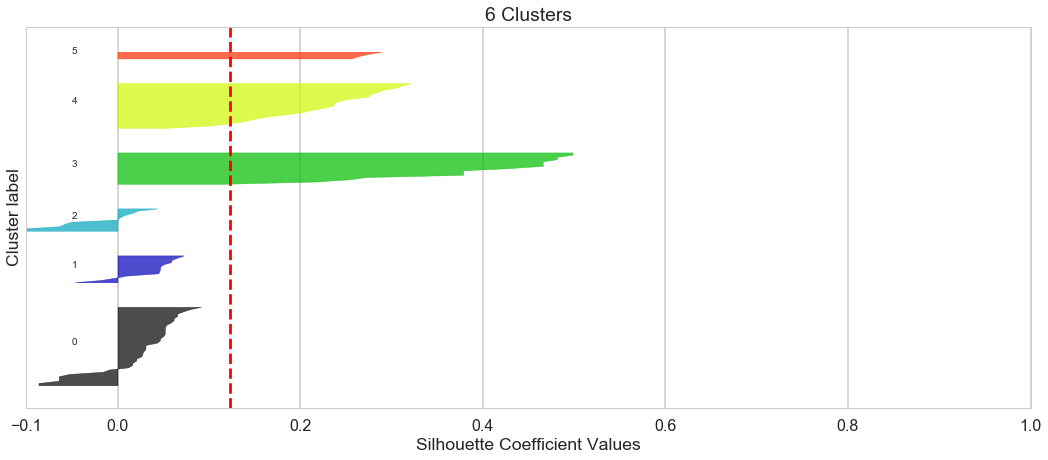

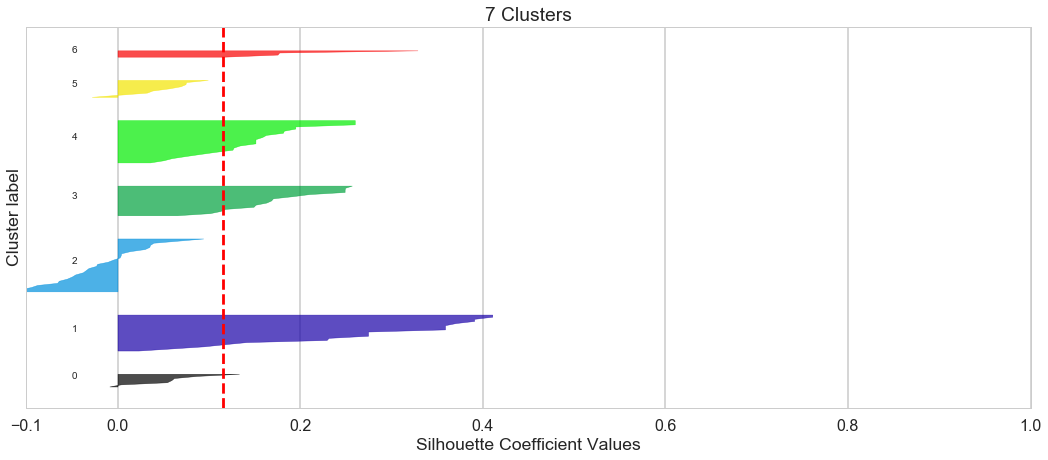

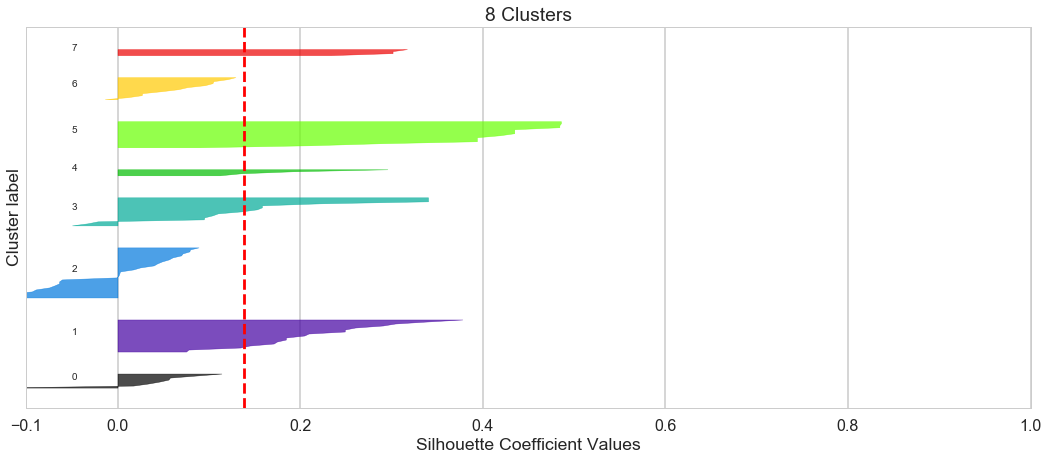

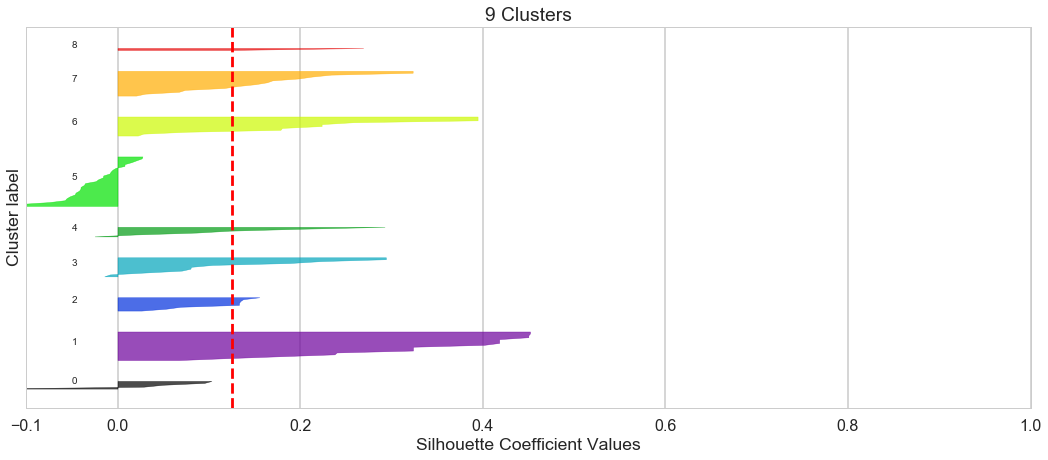

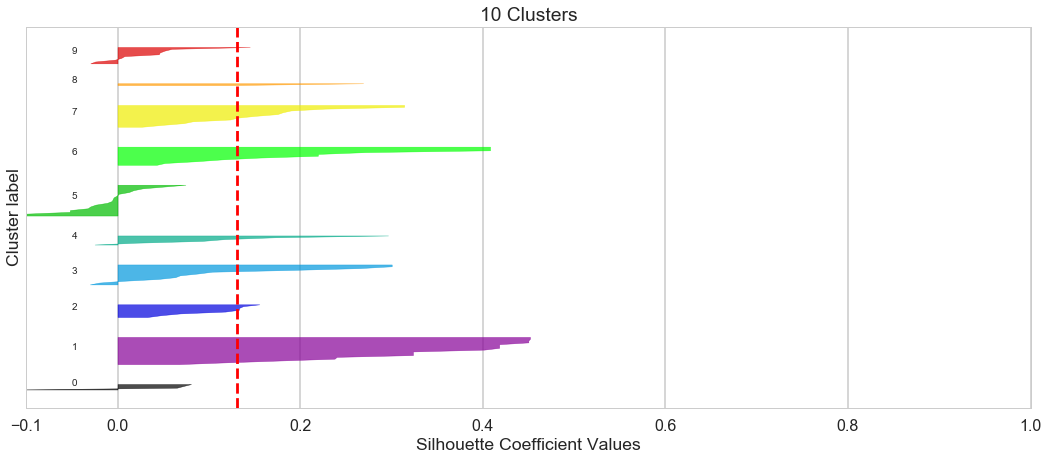

In [8]:
# Your turn.

# Import silhouette_score from sklearn.metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

silhouette_avg = np.empty(len(range_n_clusters))

# Create a series of silhouette plots
for k, cluster in enumerate(range_n_clusters):
    plt.figure(figsize=(18, 7))


# Set parameters for the silhouette plot
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(x_cols) + (cluster + 1) * 10])
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel('Silhouette Coefficient Values')
    plt.ylabel('Cluster label')
    plt.title('{} Clusters'.format(cluster))
    
# Initialize KMeans with each K cluster and fit_predict
    sil_clf = KMeans(n_clusters=cluster, random_state=22)
    sil_labels = sil_clf.fit_predict(x_cols)
    
# Compute the silhouette_score
    silhouette_avg[k] = silhouette_score(x_cols, sil_labels)
    print ("{} clusters: {}".format(cluster, silhouette_avg[k]))
    
    sample_sil_value = silhouette_samples(x_cols, sil_labels)

    
# Plot the silhouette scores
    y_lower = 10
    for i in range(cluster):
        ith_cluster_s_value = sample_sil_value[sil_labels == i]
        
        ith_cluster_s_value.sort()
        
        size_cluster_i = ith_cluster_s_value.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.spectral(float(i) / cluster)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_s_value,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
        
    plt.axvline(x=silhouette_avg[k], color='red', linestyle='--')

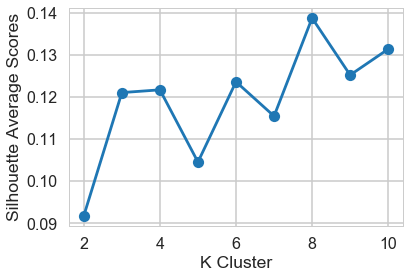

In [9]:
# Plot the silhouette average vs. k cluster

plt.plot(range(2, 11), silhouette_avg, '-o')
plt.xlabel('K Cluster')
plt.ylabel('Silhouette Average Scores')
plt.show()

The silhouette plot suggests that we use k=8, which was different from the suggest k=3 for the elbow method. The two graphical representations look drastically different. It appears that the clustering didn't perform very well.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

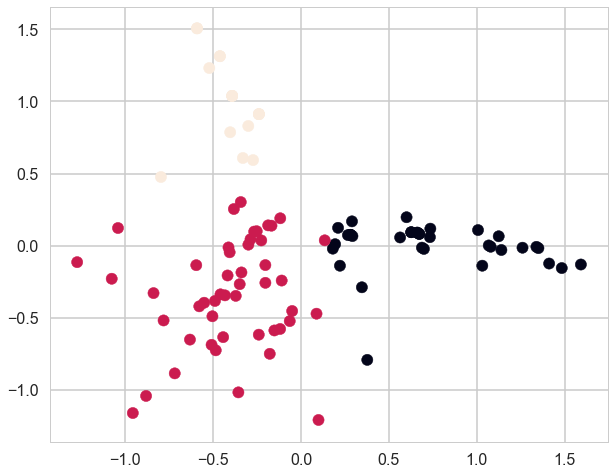

In [10]:
#your turn

# Import PCA from sklearn.decomposition
from sklearn.decomposition import PCA

# Initialize a PCA classifier with 2 components.
PCA_result = PCA(n_components=2)
result = PCA_result.fit_transform(x_cols)

# print (result.size) # 100 x 2

# Create a dataframe with the clusters from k=3
new_df = pd.DataFrame({'customer_name':df_transactions_piv['customer_name'], 'cluster_id':data,
                       'x':result[:, 0], 'y':result[:, 1]})

plt.figure(figsize=(10, 8))
plt.scatter(x=new_df['x'], y=new_df['y'], c=new_df['cluster_id'])
plt.show()

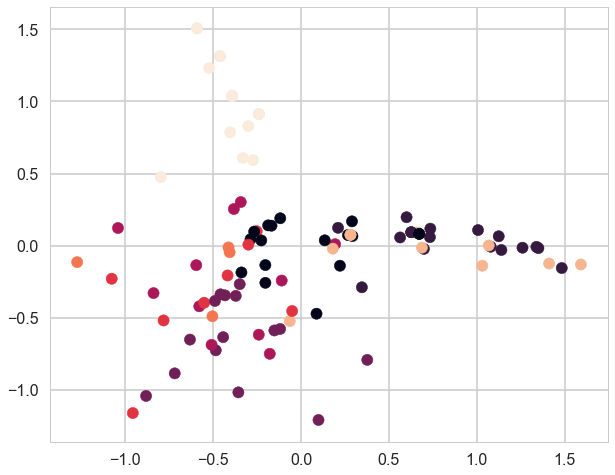

In [25]:
### Create a scatterplot for k=8
sil_clf = KMeans(n_clusters=8)
sil_data = sil_clf.fit_predict(x_cols)

sil_df = pd.DataFrame({'customer_name':df_transactions_piv['customer_name'], 'cluster_id':sil_data,
                       'x':result[:, 0], 'y':result[:, 1]})

plt.figure(figsize=(10,8))
plt.scatter(x=sil_df['x'], y=sil_df['y'], c=sil_df['cluster_id'])
plt.show()

k=3 clusters appears to have produced better results visually. In the k=8, there appears to be a lot of overlap and random distribution of clusters.

### Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [27]:
print (new_df.sort_values('cluster_id').head())

    cluster_id customer_name         x         y
0            0         Adams  1.007580  0.108215
78           0          Ross  0.210842  0.123742
57           0        Murphy  0.266997  0.073461
75           0      Robinson  0.672985  0.081453
30           0         Green  0.292635  0.066399


In [43]:
first_cluster = pd.DataFrame(new_df[new_df['cluster_id'] == 0]['customer_name'])
df_transactions_piv.merge(first_cluster).replace(0, np.nan).info()

# It appears everyone in cluster 1 of the k=3 dataframe generally bought with offer_id [7, 8, 18, 29, 30] which corresponds to
# offers with a minimum quanity of 6kg

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 33 columns):
customer_name    36 non-null object
1                0 non-null float64
2                0 non-null float64
3                2 non-null float64
4                0 non-null float64
5                0 non-null float64
6                1 non-null float64
7                16 non-null float64
8                17 non-null float64
9                0 non-null float64
10               2 non-null float64
11               1 non-null float64
12               1 non-null float64
13               6 non-null float64
14               0 non-null float64
15               0 non-null float64
16               0 non-null float64
17               0 non-null float64
18               13 non-null float64
19               1 non-null float64
20               0 non-null float64
21               2 non-null float64
22               1 non-null float64
23               0 non-null float64
24               0 non-null fl

In [45]:
second_cluster = pd.DataFrame(new_df[new_df['cluster_id'] == 1]['customer_name'])
df_transactions_piv.merge(second_cluster).replace(0, np.nan).info()

# Cluster 2 appears to be distributed all over the place. However, if we assume that this cluster isn't pure and that any 
# offer that occurs less than 8 times 9 times is misclassified, all the other offers were bought from France and Chile.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 47
Data columns (total 33 columns):
customer_name    48 non-null object
1                9 non-null float64
2                4 non-null float64
3                4 non-null float64
4                12 non-null float64
5                4 non-null float64
6                11 non-null float64
7                3 non-null float64
8                3 non-null float64
9                10 non-null float64
10               4 non-null float64
11               12 non-null float64
12               3 non-null float64
13               0 non-null float64
14               9 non-null float64
15               6 non-null float64
16               4 non-null float64
17               0 non-null float64
18               1 non-null float64
19               4 non-null float64
20               6 non-null float64
21               2 non-null float64
22               20 non-null float64
23               4 non-null float64
24               0 non-null 

In [47]:
third_cluster = pd.DataFrame(new_df[new_df['cluster_id'] == 2]['customer_name'])
df_transactions_piv.merge(third_cluster).replace(0, np.nan).info()

# Cluster 3 appears to be focused on offer_id [2, 17, 24, 26]. This cluster consists of all the Pinot Noir wines.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 33 columns):
customer_name    16 non-null object
1                1 non-null float64
2                6 non-null float64
3                0 non-null float64
4                0 non-null float64
5                0 non-null float64
6                0 non-null float64
7                0 non-null float64
8                0 non-null float64
9                0 non-null float64
10               1 non-null float64
11               0 non-null float64
12               1 non-null float64
13               0 non-null float64
14               0 non-null float64
15               0 non-null float64
16               1 non-null float64
17               7 non-null float64
18               0 non-null float64
19               0 non-null float64
20               0 non-null float64
21               0 non-null float64
22               0 non-null float64
23               1 non-null float64
24               12 non-null floa

In [22]:
df_offers.nunique()

offer_id     32
campaign     12
varietal      9
min_qty       4
discount     27
origin        9
past_peak     2
dtype: int64

It appears like the clusters correspond to a multitude of different categories.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took 
one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

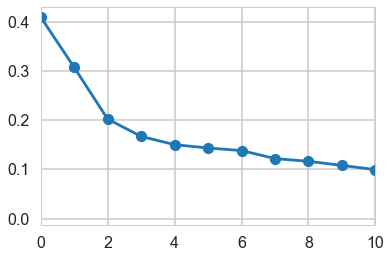

In [74]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :) 
plt.plot(pca.explained_variance_, '-o')
plt.xlim([0, 10])
plt.show()

It appears that the optimal point occurs at n_components=2.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


(array([ 9.,  0.,  0.,  3.,  0.,  0.,  0.,  6.,  0.,  0.,  0., 11.,  0.,
         0.,  0.,  7.,  0.,  0.,  0.,  3.,  0.,  0.,  0., 10.,  0.,  0.,
        11.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  8.,
         0.,  0.,  0.,  5.,  0.,  0.,  0., 12.,  0.,  0.,  8.]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14, 10.4 , 10.66, 10.92, 11.18, 11.44,
        11.7 , 11.96, 12.22, 12.48, 12.74, 13.  ]),
 <a list of 50 Patch objects>)

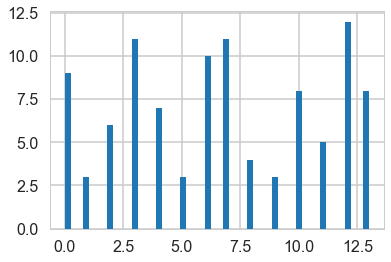

In [82]:
# Your turn

# Import the related algorithms from sklearn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

# Perform AP. No prior parameters need to be preset.
AP_clf = AffinityPropagation()
AP_data = AP_clf.fit_predict(x_cols)

plt.hist(AP_data, bins=50)

# AP separated the data into 14 clusters

(array([ 4.,  0.,  0.,  5.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  3.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,
         3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0., 50.,
         0.,  0.,  0.,  6.,  0.,  0.,  0.,  2.,  0.,  0.,  2.]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14, 10.4 , 10.66, 10.92, 11.18, 11.44,
        11.7 , 11.96, 12.22, 12.48, 12.74, 13.  ]),
 <a list of 50 Patch objects>)

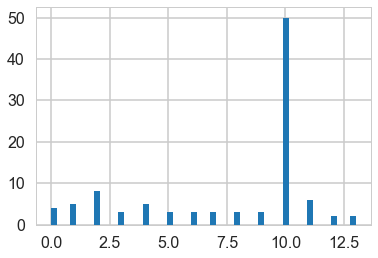

In [88]:
# Perform SC. Only prior parameters need to be preset. We'll leave it at 14 here

SC_clf = SpectralClustering(n_clusters=14)
SC_data = SC_clf.fit_predict(x_cols)

plt.hist(SC_data, bins=50)

# It appears that this algorithm yields one very strong cluster over everything else

(array([ 8.,  0.,  0., 15.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  8.,  0.,
         0.,  0., 12.,  0.,  0.,  0.,  4.,  0.,  0.,  0., 10.,  0.,  0.,
         4.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  4.,
         0.,  0.,  0.,  7.,  0.,  0.,  0.,  2.,  0.,  0.,  3.]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14, 10.4 , 10.66, 10.92, 11.18, 11.44,
        11.7 , 11.96, 12.22, 12.48, 12.74, 13.  ]),
 <a list of 50 Patch objects>)

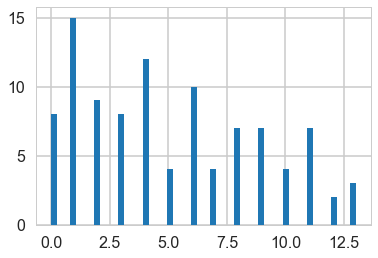

In [94]:
# Perform AC

AC_clf = AgglomerativeClustering(n_clusters=14)
AC_data = AC_clf.fit_predict(x_cols)

plt.hist(AC_data, bins=50)

# The AC algorithm appears to yield evenly distributed clusters relative to the other clustering algorithms.

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-1.5 , -1.48, -1.46, -1.44, -1.42, -1.4 , -1.38, -1.36, -1.34,
        -1.32, -1.3 , -1.28, -1.26, -1.24, -1.22, -1.2 , -1.18, -1.16,
        -1.14, -1.12, -1.1 , -1.08, -1.06, -1.04, -1.02, -1.  , -0.98,
        -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84, -0.82, -0.8 ,
        -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66, -0.64, -0.62,
        -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 ]),
 <a list of 50 Patch objects>)

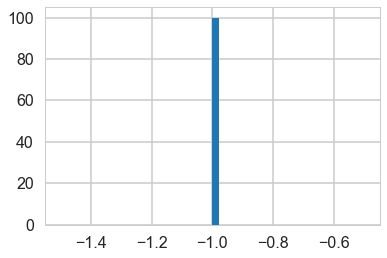

In [93]:
# Perform DBSCAN. We're going to use the default neighborhood size here.

DBS_clf = DBSCAN()
DBS_data = DBS_clf.fit_predict(x_cols)

plt.hist(DBS_data, bins=50)

# This algorithm yield a large final tree. To get smaller clusters, we'll have to cut it

Given that the data is fairly evenly distributed, the highest performing clustering algorithms for this dataset were the Affininity Propagation and Agglomerative Clustering algorithms. These both yielded fairly distributed datasets at 14 clusters. It is difficult to determine which one performed better unless we know more about the data.